In [ ]:
using DrWatson
@quickactivate "Research"

In [2]:
using Random, Statistics, LinearAlgebra, CoupledHMC, VecTargets, Plots
theme(:bright)

┌ Info: Precompiling CoupledHMC [2b235a6e-c7ff-4bf8-b98e-bb5eae5895d5]
└ @ Base loading.jl:1278
┌ Warning: Package CoupledHMC does not have VecTargets in its dependencies:
│ - If you have CoupledHMC checked out for development and have
│   added VecTargets as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with CoupledHMC
└ Loading VecTargets into CoupledHMC from project dependency, future warnings for CoupledHMC are suppressed.


In [3]:
Random.seed!(1)
n_mc_max = 10_000
n_iters = 75
target = HighDimGaussian(2)

HighDimGaussian{VecTargets.BroadcastedNormalStd{Float64,Array{Float64,1},Array{Float64,1}}}(
bn: VecTargets.BroadcastedNormalStd{Float64,Array{Float64,1},Array{Float64,1}}(m=[0.0, 0.0], s=[1.0, 1.0])
)


In [4]:
function run_mcmc()
    alg = HMCSampler(rinit=rand, TS=MultinomialTS, ϵ=0.2, L=10)
    samples = CoupledHMC.sample(target, alg, n_iters)
    return mean(samples)
end

mean_ests = [run_mcmc() for _ in 1:n_mc_max]

function run_coupled_mcmc(; k=10)
    alg = CoupledHMCSampler(rinit=rand, TS=MultinomialTS, ϵ=0.2, L=10)
    samples = CoupledHMC.sample(target, alg, n_iters)
    τ = τ_of(samples)
    return H_of(x -> x, samples, k, τ, n_iters)
end

mean_unbiased_ests = [run_coupled_mcmc() for _ in 1:n_mc_max]

;

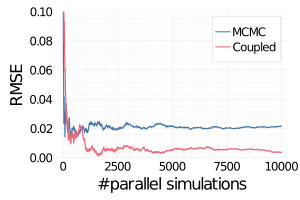

In [5]:
p = plot(; size=(300, 200), ylims=(0, 0.1))
n_thinning = 10
n_mc_thinned = 1:n_thinning:n_mc_max
plot!(p, n_mc_thinned, [norm(mean(mean_ests[1:n_mc]))          for n_mc in n_mc_thinned], label="MCMC")
plot!(p, n_mc_thinned, [norm(mean(mean_unbiased_ests[1:n_mc])) for n_mc in n_mc_thinned], label="Coupled")
xlabel!("#parallel simulations")
ylabel!("RMSE")
p